# Fitting Saturation-based Simulation Data With Multi-Output
Can having multiple labels per data improve validation loss? 


In [63]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from model_trainer import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN
)

from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [65]:
# file_name = 'logI2_by_I1'
# file_name = 'I1_and_I2'
# file_name = 'pulsation_ratio'
file_name = "I1_and_I2_interp"
# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.json"
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

# Convert to log
# data[features] = np.log(data[features])



In [66]:
# I1 by I2 path

from inverse_modelling_tfo.features.build_features import TwoColumnOperationFeatureBuilder

i1_wv2 = features[:len(features)//4]
i1_wv1 = features[len(features)//4:2*len(features)//4]
i2_wv2 = features[2*len(features)//4:3*len(features)//4]
i2_wv1 = features[3*len(features)//4:]

# Create the feature builders
fb1 = TwoColumnOperationFeatureBuilder(i2_wv1, i1_wv1, '/', False, features, labels)
fb2 = TwoColumnOperationFeatureBuilder.from_chain(fb1, i2_wv2, i1_wv2, '/', False)

# Transform the data
data = fb2(data)

features = fb2.get_feature_names()

# Cleanup
data.dropna(inplace=True)

In [67]:
data.describe()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 1,Fetal Hb Concentration 2,10_1.0_2_/_10_1.0_1,15_1.0_2_/_15_1.0_1,19_1.0_2_/_19_1.0_1,...,55_2.0_2_/_55_2.0_1,59_2.0_2_/_59_2.0_1,64_2.0_2_/_64_2.0_1,68_2.0_2_/_68_2.0_1,72_2.0_2_/_72_2.0_1,77_2.0_2_/_77_2.0_1,81_2.0_2_/_81_2.0_1,86_2.0_2_/_86_2.0_1,90_2.0_2_/_90_2.0_1,94_2.0_2_/_94_2.0_1
count,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,...,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000
mean,19.000000,13.000000,0.950000,0.400000,4.000000,12.675000,13.000000,0.999966,0.999818,0.999558,...,0.996413,0.995981,0.996017,0.995063,0.994112,0.992926,0.991981,0.990801,0.989861,0.988923
std,8.944281,1.290996,0.031623,0.121106,2.738615,1.335075,1.369308,0.000108,0.000499,0.001104,...,0.006326,0.007032,0.004931,0.004793,0.004959,0.005544,0.006238,0.007291,0.008230,0.009225
min,4.000000,11.000000,0.900000,0.200000,0.000000,10.725000,11.000000,0.999422,0.997501,0.994738,...,0.979319,0.976901,0.986528,0.986379,0.983319,0.976999,0.971972,0.965725,0.960757,0.955814
25%,11.000000,12.000000,0.920000,0.300000,1.750000,11.578125,11.875000,0.999996,0.999974,0.999881,...,0.996449,0.995897,0.990542,0.989976,0.989586,0.989104,0.988439,0.987662,0.986722,0.985239
50%,19.000000,13.000000,0.950000,0.400000,4.000000,12.675000,13.000000,0.999999,0.999999,0.999999,...,0.999974,0.999970,1.000000,0.997142,0.994893,0.992200,0.990703,0.989951,0.989624,0.989139
75%,27.000000,14.000000,0.980000,0.500000,6.250000,13.771875,14.125000,1.000001,1.000000,1.000000,...,0.999999,0.999999,1.000144,0.999781,0.999366,0.998856,0.998452,0.997949,0.997548,0.997147
max,34.000000,15.000000,1.000000,0.600000,8.000000,14.625000,15.000000,1.000017,1.000010,1.000008,...,1.000005,1.000006,1.001560,1.000000,1.000000,1.000000,0.999999,0.999999,0.999999,0.999999


In [68]:
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 2.0)
    & (data["Maternal Wall Thickness"] <= 12.0)
    # & (np.round(data["Fetal Hb Concentration"], fconc_rounding).isin(groups_to_keep))
    & (data["Fetal Saturation"] > 0.3)
    & (data["Maternal Saturation"] > 0.95)
]
print("training with", len(data), "samples")

training with 48600 samples


# Setup Training Objective

In [69]:
y_columns = labels  # What to Predict
# Add New ConcDiff Column as a new label
# data["ConcDiff"] = data["Fetal Hb Concentration 1"] - data["Fetal Hb Concentration 0"]
# if "ConcDiff" not in y_columns:
#     y_columns.append("ConcDiff")

# if "Fetal Hb Concentration 1" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 1")

# if "Fetal Hb Concentration 0" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 0")

if "FconcCenters" in y_columns:
    y_columns.remove("FconcCenters")
print("Y Columns", y_columns)

x_columns = features  # What to use as input

## Use only first N detectors
# N = 10
# x_columns = features[:N] + features[(len(features)//2): (len(features)//2 + N)]

print("X Columns", x_columns)

Y Columns ['Maternal Wall Thickness', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Saturation', 'Fetal Hb Concentration 1', 'Fetal Hb Concentration 2']
X Columns ['10_1.0_2_/_10_1.0_1', '15_1.0_2_/_15_1.0_1', '19_1.0_2_/_19_1.0_1', '24_1.0_2_/_24_1.0_1', '28_1.0_2_/_28_1.0_1', '33_1.0_2_/_33_1.0_1', '37_1.0_2_/_37_1.0_1', '41_1.0_2_/_41_1.0_1', '46_1.0_2_/_46_1.0_1', '50_1.0_2_/_50_1.0_1', '10_2.0_2_/_10_2.0_1', '15_2.0_2_/_15_2.0_1', '19_2.0_2_/_19_2.0_1', '24_2.0_2_/_24_2.0_1', '28_2.0_2_/_28_2.0_1', '33_2.0_2_/_33_2.0_1', '37_2.0_2_/_37_2.0_1', '41_2.0_2_/_41_2.0_1', '46_2.0_2_/_46_2.0_1', '50_2.0_2_/_50_2.0_1']


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [70]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Scheme 2 - All detector combined normalization
# x_scaler = preprocessing.StandardScaler()
# # Assume the entire data lies between -1 to -20 (log scale) -> z = (x - u) / s -> zs - x = -u; s = 19/2 = 9.5;
# # at z = +1, x = -1, at z = -1, x = -20, u = 10.5, so we should be converting from -1 to -20 to -1 to 1
# # Use these values to manually define the scaler
# feature_len  = len(x_columns)
# x_scaler.scale_ = np.array([9.5] * feature_len)
# x_scaler.mean_ = np.array([10.5] * feature_len)
# x_scaler.n_features_in_ = feature_len
# x_scaler.feature_names_in_ = x_columns  # Avoids a warning/not really necessary
# data[x_columns] = x_scaler.transform(data[x_columns])


## Model Configuration

In [71]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 20
Out Features: 6


# Setting up Special Residual Network 

In [72]:
# saturation_unique_values = data["Fetal Saturation"].unique()
# mean_saturation_level = saturation_unique_values[len(saturation_unique_values)//2]
# # Convert to float tensor, by default it is double
# lookup_table = torch.from_numpy(data[data["Fetal Saturation"] == mean_saturation_level].values).cuda().float()
# feature_indices = [data.columns.get_loc(feature) for feature in x_columns]
# feature_indices = torch.tensor(feature_indices).cuda()
# intermediate_labels = y_columns.copy()
# intermediate_labels.remove("Fetal Saturation")
# intermediate_label_indices = [data.columns.get_loc(label) for label in intermediate_labels]
# intermediate_labels = torch.tensor(intermediate_label_indices).cuda()

# # y_columns = ["Fetal Saturation"]

# feature_res_net_params = {
#         'node_count_left': [len(x_columns), 5, len(intermediate_labels)],
#         'dropout_rates_left': [0.5, 0.5],
#         'node_count_right': [len(x_columns), 5, len(y_columns)],
#         'dropout_rates_right': [0.5, 0.5],
#         'lookup_table': lookup_table,
#         'lookup_key_indices': intermediate_labels,
#         'feature_indices': feature_indices,
# }


# Training Configs

In [86]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from model_trainer import ModelTrainer, TorchLossWrapper, DataLoaderGenerator, SumLoss

# Create an individual loss for each label
criterion_list = []
criterion_names = ['depth', 'mom_hb', 'mom_sat', 'fet_sat', 'fet_hb1', 'fet_hb2']

for index, name in enumerate(criterion_names):
    criterion_list.append(TorchLossWrapper(nn.MSELoss(), [index], name))

# Sum the losses
criterion = SumLoss(criterion_list, weights=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0])


set_seed(40)

# validation_method = RandomSplit(0.7)
all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut('Maternal Wall Thickness', all_depths[len(all_depths)//2])   # Center value

dataloader_gen = DataLoaderGenerator(data, x_columns, y_columns, 32, {'shuffle': True})

## Trainer Factory - Perceptrons
# model = PerceptronBD([IN_FEATURES, 40, 20, 10, 6, OUT_FEATURES])    # Works
model = PerceptronBD([IN_FEATURES, 40, 20, OUT_FEATURES])     # Current Best
# model = PerceptronBD([IN_FEATURES, 20, 10, OUT_FEATURES])    


## Trainer Factory - CNNs
# cnn_config = {
#     'input_length': IN_FEATURES,
#     'cnn_out_channels': [4, 8, 16],
#     'cnn_kernel_sizes' : [10, 10, 10],
#     'fc_output_node_counts': [20, 10, OUT_FEATURES],
# }
# trainer_factory = ModelTrainerFactory(CNN2FC2dInput, cnn_config, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - SplitChannel CNNs
# cnn_config = {
#     'complete_input_length': IN_FEATURES,
#     'split_count': 4,
#     'cnn_out_channels': [4, 8, 16],
#     # 'cnn_kernel_sizes' : [10, 5, 5],
#     'cnn_kernel_sizes' : [10, 5, 3],
#     'cnn_dropouts' : [0.5] * 2,
#     # 'fc_output_node_counts': [30, 10, OUT_FEATURES],    # Best
#     # 'fc_output_node_counts': [24, 12, OUT_FEATURES],    # Best
#     'fc_output_node_counts': [12, 6, OUT_FEATURES],    # Best
#     'fc_dropouts': [0.5] * 3,
# }

# model = SplitChannelCNN(**cnn_config)

trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)

## Custom Training

In [87]:
# trainer.set_optimizer(SGD, {'lr': 4e-4, 'momentum': 0.98, 'weight_decay': 1e-4})
trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.98, 'weight_decay': 1e-4})      # Current Best
# trainer.set_batch_size(2048)
# trainer.set_batch_size(32)
trainer.run(50) 

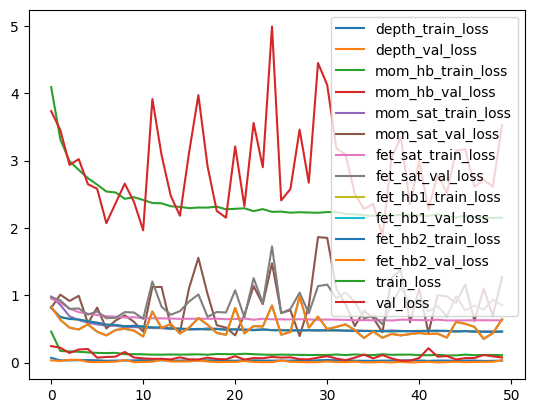

In [88]:
plt.figure()
criterion.loss_tracker.plot_losses()
# plt.yscale('log')
plt.legend()

loss_curves = plt.gcf()

In [89]:
from tabulate import tabulate

mse_table = []
for loss in criterion.loss_tracker.epoch_losses.keys():
    mse_table.append([loss, criterion.loss_tracker.epoch_losses[loss][-1]])

print(tabulate(mse_table, headers=['Loss Name', 'MSE']))

Loss Name                 MSE
------------------  ---------
depth_train_loss    0.0299947
depth_val_loss      0.0356417
mom_hb_train_loss   0.110421
mom_hb_val_loss     0.0763542
mom_sat_train_loss  0.461934
mom_sat_val_loss    1.27324
fet_sat_train_loss  0.62843
fet_sat_val_loss    0.855208
fet_hb1_train_loss  0.461357
fet_hb1_val_loss    0.643512
fet_hb2_train_loss  0.461357
fet_hb2_val_loss    0.643512
train_loss          2.15349
val_loss            3.52747


In [90]:
# Increase batch_size for faster visuals generation - (does not affect training!)
prev_batch_size = dataloader_gen.batch_size
trainer.set_batch_size(4096)
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)
trainer.set_batch_size(prev_batch_size)

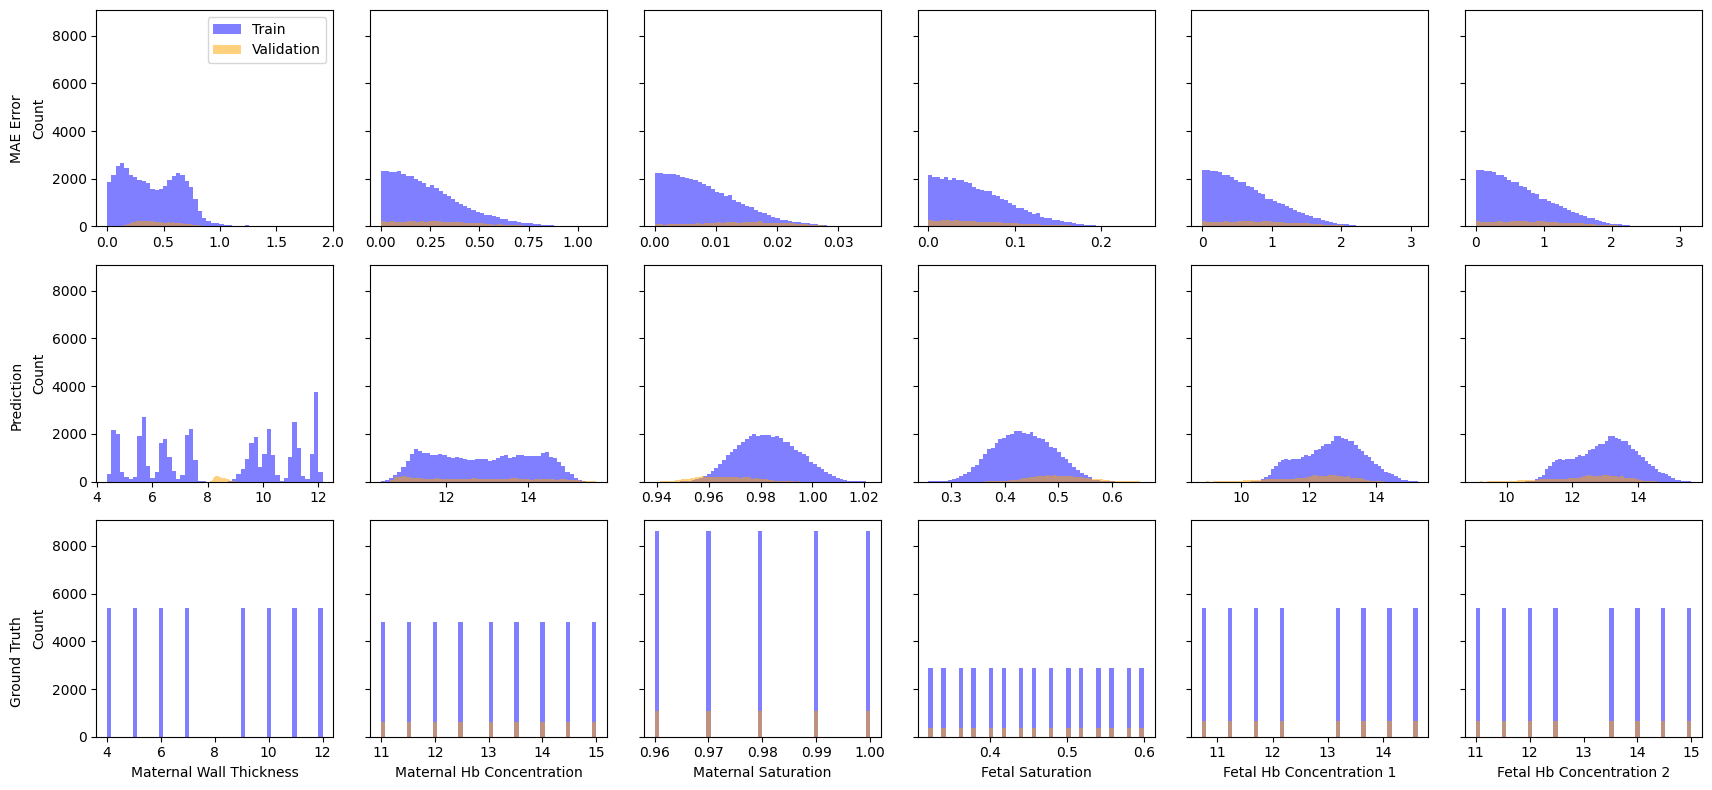

In [91]:
fig_dist, axes = plt.subplots(3, len(y_columns), squeeze=True, figsize=(17, 8), sharey=True)
BIN_COUNT = 50

train_data = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1].cpu())
val_data = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1].cpu())

for i in range(len(y_columns)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Ground Truth
    ax = axes[2, i]
    plt.sca(ax)
    plt.hist(train_data[:, i], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_data[:, i], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    # X Label for the bottommost row
    plt.xlabel(y_columns[i])
    
# Add text to the left of each row of plots
for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
    fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# Y Labels
for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('Count')

# Add labels to top-left subplot
axes[0, 0].legend()


plt.tight_layout()
plt.show()

In [92]:
from tabulate import tabulate
# For each column, also print out the mean and std of the errors
mae_table = []


for i in range(len(y_columns)):
    column_name = train_error.columns[i]
    mae_table.append([column_name, train_error[column_name].mean(), train_error[column_name].std(), val_error[column_name].mean(), val_error[column_name].std()])

print(tabulate(mae_table, headers=['Column', 'Train Mean', 'Train Std', 'Validation Mean', 'Validation Std']))

Column                             Train Mean    Train Std    Validation Mean    Validation Std
-------------------------------  ------------  -----------  -----------------  ----------------
Maternal Wall Thickness Error      0.407566     0.261622            0.45199          0.182472
Maternal Hb Concentration Error    0.24342      0.183514            0.300663         0.191951
Maternal Saturation Error          0.00828211   0.00600498          0.0141945        0.00729135
Fetal Saturation Error             0.0576506    0.0415772           0.0647509        0.0468131
Fetal Hb Concentration 1 Error     0.655232     0.483021            0.899917         0.581009
Fetal Hb Concentration 2 Error     0.672033     0.495407            0.922992         0.595907


In [93]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       840
│    └─BatchNorm1d: 2-2                  80
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       820
│    └─BatchNorm1d: 2-5                  40
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       126
│    └─Flatten: 2-8                      --
Total params: 1,906
Trainable params: 1,906
Non-trainable params: 0

In [94]:
# ## Save Model Code
# model_name = 'multi_output_holdoneout_split'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../../models/{model_name}_yscaler')

In [95]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [96]:
# from inverse_modelling_tfo.misc import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report7', 'Inverse Modelling Report')
# report.add_text_report("Objective", "Predicting with 90% Random Split(As opposed to a hold One out style). Same as report6. Except, trying out a different normalization scheme. Where it scales all detector intensity logs using a single scale. More specifically, maps the values from -1 to -20 between -1 and +1. The intuition behind this was that this sort of normalization should preserve inter-detector scaling.")
# report.add_text_report("Comments", "Somehow performs slightly worse than per detector scaling. Which does not make sense to me")
# report.add_text_report("Data Length", str(len(data)))
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", loss_curves)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()